In [1]:
# Importing OS and Pathlib, so that we can work with files in our directories/PC
import os
import pathlib

# Some basic libraries that help us create dataframes and visualizations.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
plt.style.use("fivethirtyeight")
%matplotlib inline

# Deep Learning Libraries like Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Flatten

# To Suppress any Un-necessary warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Here, we define the paths where we have our data for training, testing and predictions
data_dir_train = pathlib.Path('../train')
data_dir_test = pathlib.Path('../test')
data_dir_val = pathlib.Path('../pred')

In [3]:
# Checking the number images in all the paths defined above
print("Number of Images in Train:", len(list(data_dir_train.glob("*/*.png"))))
print("Number of Images in Test:", len(list(data_dir_test.glob("*/*.png"))))
print("Number of Images in Validation:", len(list(data_dir_val.glob("*/*.png"))))

Number of Images in Train: 8603
Number of Images in Test: 623
Number of Images in Validation: 623


In [4]:
# Here, we are defining some variables which will be commonly used in the further codes
height = 150
width = 150
batch_size = 16
seed = 42 # For reproducibility 

In [5]:
train_ds = keras.preprocessing.image_dataset_from_directory(
data_dir_train,
seed=seed,
validation_split=0.2,
subset='training',
image_size=(height,width),
batch_size=batch_size)

Found 8603 files belonging to 3 classes.
Using 6883 files for training.


In [8]:
# Second we ask Keras to create a "validation" dataset with 0.2 as validation split.

val_ds = keras.preprocessing.image_dataset_from_directory(
data_dir_train,
seed=seed,
validation_split=0.2,
subset='validation',
image_size=(height,width),
batch_size=batch_size)

Found 8603 files belonging to 3 classes.
Using 1720 files for validation.


In [9]:
class_names = train_ds.class_names
class_names

['Covid', 'Normal', 'Viral_Pneumonia']

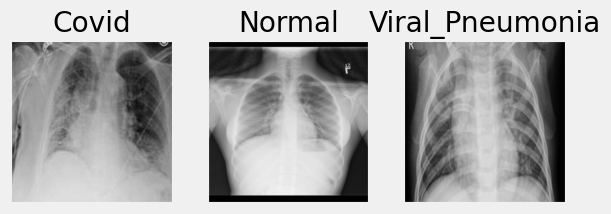

In [10]:
for index, classes in enumerate(class_names):
    for images in train_ds.file_paths:
        if classes in images:
            img = image.imread(images)
            plt.subplot(1,3,index+1)
            plt.imshow(img, cmap=plt.cm.gist_gray)
            plt.xticks([])
            plt.yticks([])
            plt.title(str(classes))
            break
plt.show()

In [11]:
# Here we start building our model in Keras:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(height, width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
!pip install visualkeras


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


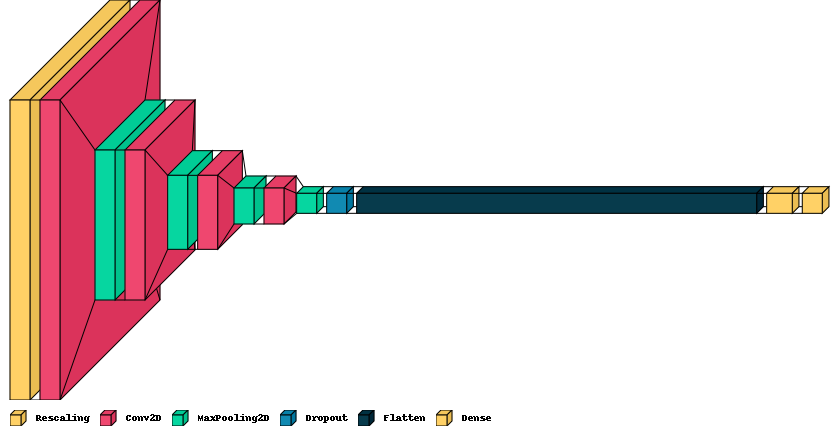

In [14]:
import visualkeras
visualkeras.layered_view(model, scale_xy=2, legend=True)

In [15]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
431/431 [==============================] - 62s 141ms/step - loss: 0.4768 - accuracy: 0.7973 - val_loss: 0.3585 - val_accuracy: 0.8657
Epoch 2/20
431/431 [==============================] - 61s 141ms/step - loss: 0.2518 - accuracy: 0.9053 - val_loss: 0.1868 - val_accuracy: 0.9326
Epoch 3/20
431/431 [==============================] - 61s 142ms/step - loss: 0.1874 - accuracy: 0.9313 - val_loss: 0.1765 - val_accuracy: 0.9390
Epoch 4/20
431/431 [==============================] - 61s 142ms/step - loss: 0.1400 - accuracy: 0.9468 - val_loss: 0.1253 - val_accuracy: 0.9552
Epoch 5/20
431/431 [==============================] - 61s 142ms/step - loss: 0.1064 - accuracy: 0.9615 - val_loss: 0.1307 - val_accuracy: 0.9506
Epoch 6/20
431/431 [==============================] - 61s 142ms/step - loss: 0.0837 - accuracy: 0.9680 - val_loss: 0.1180 - val_accuracy: 0.9570
Epoch 7/20
431/431 [==============================] - 61s 141ms/step - loss: 0.0887 - accuracy: 0.9691 - val_loss: 0.1467 - val_ac

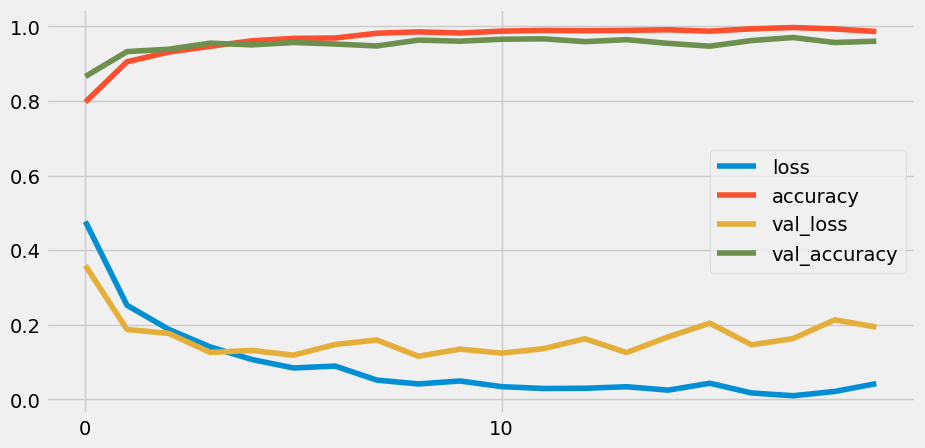

In [16]:
# Next we are going to plot a graph to check the loss and accuracy as the model trained for 20 epochs for both train and validation.
pd.DataFrame(history.history).plot(figsize=[10,5])
plt.yticks(np.linspace(0,1,6))
plt.xticks(np.linspace(0,10,2))
plt.show()

In [17]:
# To evaluate our model, we are going to make use of the "test" dataset
test_ds = keras.preprocessing.image_dataset_from_directory(
data_dir_test,
seed=seed,
image_size=(height,width),
batch_size=batch_size)

Found 623 files belonging to 3 classes.


In [18]:
model.evaluate(test_ds, batch_size=batch_size)

39/39 [==============================] - 2s 54ms/step - loss: 0.1123 - accuracy: 0.9695


[0.11225113272666931, 0.9695023894309998]

### IMPORTANT NEW INFO

In [19]:
# The Next step is to save the model. This is our trained model. We saved it so that we do not need to train it again and again.

# I am saving this in the .h5 format.

model.save("./xray_model.h5")

1/1 [==============================] - 0s 70ms/step


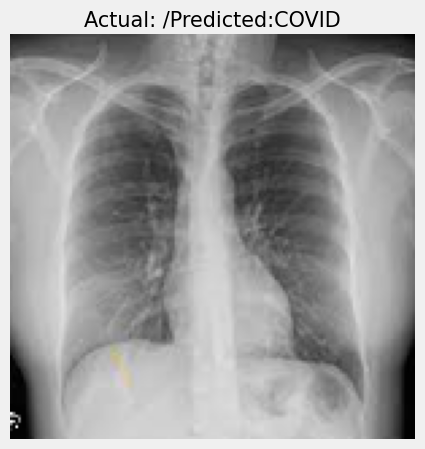

In [22]:
# Loading the .h5 model that we had saved in the previous step:
my_xray_cnnmodel = keras.models.load_model("./xray_model.h5")

# Defining an image path from the "pred" folder:
image_path = 'C:/Users/walid/Desktop/2.png'

# Preprocessing the image to 150x150x3 size and predicting the label:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(150,150,3))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = my_xray_cnnmodel.predict(input_arr)

classes = ["NORMAL","COVID","Viral_PNEUMONIA"]

actual = ''

for class_name in classes:
    if class_name in image_path:
        actual = class_name

pred = classes[np.argmax(predictions, axis=1)[0]]

# Finally we are displaying the predicted outcome:
plt.figure(figsize=[8,5])
plt.imshow(image, cmap='gray')
plt.title("Actual:"+actual+" /Predicted:"+pred, size=15)
plt.axis('off')
plt.show()